This notebook fits a hierarchical GLM-HMM. The model includes observed discrete states $z_t \in \{1,...,N \}$, unobserved hidden states $w_t \in \{1,...,M\}$, and external inputs $u_t \in \mathbb{R}^U$. The external inputs modify the transition probabilities between the observed states according to a GLM, where the weights of the GLM depend on the hidden states. Formally, the states as generated by the following model:

$$ w_t \mid w_{t-1} \sim \text{Categorical}(\pi_{w_{t-1}}) $$

$$ z_t \mid z_{t-1}, w_t, u_t \sim \text{Categorical}(\exp(B_{w_t} u_t)+P_{z_{t-1}}) $$

where $\pi$ is the transition matrix between hidden states, $\mathbf{B}_i \in \mathbb{R}^{N \times U}, i=1,...,M$ are GLM weight matrices, and $P \in \mathbb{R}^{N \times N}$ is the baseline transition matrix between observed states. The parameters are generated by the following prior distributions:

$$ \pi \sim \text{sticky-HDP}(\gamma, \alpha, \kappa) $$

$$ B_{i,j} \sim \text{Normal}(0, \sigma_B^2)$$

$$ P_{i,j} \sim \text{Normal}(0, \sigma_P^2)$$

In [60]:
import jax
import jax.numpy as jnp
import jax.random as jr
import blackjax

from jax_moseq.utils.distributions import sample_hmm_stateseq
from jax_moseq.utils.transitions import resample_hdp_transitions, init_hdp_transitions
from jax_moseq.utils import pad_along_axis
from functools import partial
na = jnp.newaxis


def resample_glm_params(seed, z, u, w, mask, P, B, sigmasq_P, sigmasq_B, 
                        step_size=1e-3, num_steps=10, **kwargs):
    """
    Resamples the GLM weights and baseline transition matrix using HMC.

    Parameters
    ----------
    seed : jr.PRNGKey
        JAX random seed.
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    w : jnp.ndarray of shape (num_seqs, T)
        Hidden states.
    mask : jnp.ndarray of shape (num_seqs, T)
        Mask for observed data.
    P_init : jnp.ndarray of shape (N, N)
        Initial baseline transition matrix for the observed states.
    B_init : jnp.ndarray of shape (M, N, U)
        Initial GLM weights for each hidden state.
    sigmasq_P : float
        Prior variance for each element of the baseline transition matrix.
    sigmasq_B : float
        Prior variance for each element of the GLM weights.
    step_size : float
        HMC step size.
    num_steps : int
        Number of HMC integration steps.

    Returns
    ------
    P : jnp.ndarray of shape (N, N)
        Updated baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (M, N, U)
        Updated GLM weights for each hidden state.
    """

    def logprob_fn(P, B):
        log_likelihood = (glm_log_likelihood(z, u, P, B[w]) * mask).sum()
        log_prior = -0.5 * (P**2 / sigmasq_P + B**2 / sigmasq_B).sum()
        return log_likelihood + log_prior

    hmc = blackjax.hmc(logprob_fn, step_size, num_integration_steps=num_steps)
    (P,B), info = hmc.step(seed, hmc.init((P_init, B_init)))
    return P, B


def glm_log_likelihood(z, u, P, B):
    """
    Computes the log-likelihood of each observed transition under the GLM.

    Parameters
    ----------
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    P : jnp.ndarray of shape (N, N)
        Baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (N, U)
        GLM weights.

    Returns
    -------
    log_likelihoods : jnp.ndarray of shape (num_seqs, T)
        Log-likelihoods under the GLM.
    """
    baseline = pad_along_axis(P[z[...,1:]], (1,0), axis=-2, value=0)
    bias = (B @ u[...,na]).squeeze(-1)
    normalizer = jax.nn.logsumexp(baseline + bias, axis=-1)
    log_likelihoods = jnp.take_along_axis(baseline + bias, z[...,na], axis=-1).squeeze(-1) - normalizer
    return log_likelihoods
    

#@jax.jit
def resample_discrete_stateseqs(seed, z, u, mask, pi, P, B, **kwargs):
    """
    Resamples the discrete state sequence ``w``.

    Parameters
    ----------
    seed : jr.PRNGKey
        JAX random seed.
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    mask : jnp.ndarray of shape (num_seqs, T)
        Mask for observed data.
    pi : jnp.ndarray of shape (M, M)
        Hidden state transition matrix.
    P : jnp.ndarray of shape (N, N)
        Baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (M, N, U)
        GLM weights for each hidden state.

    Returns
    ------
    w : jax_array of shape (num_seqs, T)
        Discrete state sequences.
    """
    num_seqs = mask.shape[0]
    log_likelihoods = jax.lax.map(partial(glm_log_likelihood, z, u, P), B)
    _, w = jax.vmap(sample_hmm_stateseq, in_axes=(0,na,0,0))(
        jr.split(seed, num_seqs),
        pi,
        jnp.moveaxis(log_likelihoods,0,-1),
        mask.astype(float))
    return w


def resample_model(data, seed, states, params, hypparams, states_only=False, **kwargs):
    """
    Resample the GLM-HMM model. 

    Below, `T` is the number of time steps, `M` is the number of hidden states,
    `N` is the number of observed states, and `U` is the number of external inputs.

    Parameters
    ----------
    data : dict
        Data dictionary containing
        - `z` : jnp.ndarray of shape (num_seqs, T)
            Observed discrete states.
        - `u` : jnp.ndarray of shape (num_seqs, T, U)
            Observed external inputs.
        - `mask` : jnp.ndarray of shape (num_seqs, T)
            Mask for observed data.

    seed : jr.PRNGKey
        JAX random seed.

    states : dict
        State dictionary containing
        - `w` : jnp.ndarray of shape (num_seqs, T)
            Hidden states.

    params : dict
        Parameter dictionary containing
        - `pi` : jnp.ndarray of shape (M, M)
            Hidden state transition matrix.
        - `betas` : jnp.ndarray of shape (M,)
            Global concentration weights for the HDP prior over hidden state transitions.
        - `P` : jnp.ndarray of shape (N, N)
            Baseline transition matrix for the observed states.
        - `B` : jnp.ndarray of shape (M, N, U)
            GLM weights for each hidden state.
            
    hypparams : dict
        Dictionary with two groups of hyperparameters:
        - trans_hypparams : dict
            HDP transition hyperparameters (see 
            `jax_moseq.models.glm_hmm.initialize.init_glm_params`)
        - glm_hypparams : dict
            GLM hyperparameters (see `jax_moseq.utils.transitions.init_hdp_transitions`)

    states_only : bool, default=False
        Only resample states if True.

    Returns
    ------
    model : dict
        Dictionary containing the hyperparameters and
        updated seed, states, and parameters of the model.
    """
    seed = jr.split(seed)[1]

    if not states_only: 
        params['betas'], params['pi'] = resample_hdp_transitions(
            seed, **data, **states, **params,
            **hypparams['trans_hypparams'])
        
        params['P'], params['B']= resample_glm_params(
            seed, **data, **states, **params, 
            **hypparams['glm_hypparams'])

    states['w'] = resample_discrete_stateseqs(
        seed, **data, **states, **params)

    return {'seed': seed,
            'states': states, 
            'params': params, 
            'hypparams': hypparams}


######################################################################

def init_glm_params(seed, sigmasq_B, sigmasq_P, input_dim, 
                    num_observed_states, num_states, **kwargs):
    """
    Initialize GLM weights `B` and baseline transition matrix `P` form their priors.
    """
    P = jr.normal(seed, (num_observed_states, num_observed_states)) * sigmasq_P**0.5
    B = jr.normal(seed, (num_states, num_observed_states, input_dim)) * sigmasq_B**0.5
    return P, B


def init_params(seed, trans_hypparams, glm_hypparams, **kwargs):
    """
    Initialize the parameters of the GLM-HMM model.
    """
    params = {}
    params['betas'], params['pi'] = init_hdp_transitions(seed, **trans_hypparams)
    params['P'], params['B'] = init_glm_params(seed, **glm_hypparams, **trans_hypparams)
    return params
 

def init_model(data=None,
               states=None,
               params=None,
               hypparams=None,
               seed=jr.PRNGKey(0),
               verbose=False,
               **kwargs):
    """
    Initialize the GLM-HMM model.

    Below, `T` is the number of time steps, `M` is the number of hidden states,
    `N` is the number of observed states, and `U` is the number of external inputs.

    Parameters
    ----------
    data : dict
        Data dictionary containing
        - `z` : jnp.ndarray of shape (num_seqs, T)
            Observed discrete states.
        - `u` : jnp.ndarray of shape (num_seqs, T, U)
            Observed external inputs.
        - `mask` : jnp.ndarray of shape (num_seqs, T)
            Mask for observed data.

    hypparams : dict
        Dictionary with two groups of hyperparameters:
        - trans_hypparams : dict
            HDP transition hyperparameters, including `alpha`, `gamma`, `kappa`,
            and `num_states` (see `jax_moseq.utils.transitions.init_hdp_transitions`)
        - glm_hypparams : dict
            GLM hyperparameters, including `sigmasq_P`, `sigmasq_B`,
            `num_steps`, `step_size`, `input_dim` and `num_observed_states`
            (see `jax_moseq.models.glm_hmm.initialize.init_glm_params`, and
             `jax_moseq.models.glm_hmm.initialize.resample_glm_params`) 

    states : dict, optional
        Initial values for the states, as a dictionary containing:
        - `w` : jnp.ndarray of shape (num_seqs, T)
            Hidden states.

    params : dict, optional
        Initial values for the parameters, as a dictionary containing:
        - `pi` : jnp.ndarray of shape (M, M)
            Hidden state transition matrix.
        - `betas` : jnp.ndarray of shape (M,)
            Global concentration weights for the HDP prior over hidden state transitions.
        - `P` : jnp.ndarray of shape (N, N)
            Baseline transition matrix for the observed states.
        - `B` : jnp.ndarray of shape (M, N, U)
            GLM weights for each hidden state.

    seed : int or jr.PRNGKey, default=jr.PRNGKey(0)
        Initial JAX random seed.

    verbose : bool, default=False
        Whether to print progress info during initialization.

    Returns
    -------
    model : dict
        Dictionary containing the hyperparameters and
        initial seed, states, and parameters of the model.
        
    Raises
    ------
    ValueError
        If the subset of the parameters provided by the caller
        is insufficient for model initialization.
    """
    #_check_init_args(data, states, params, hypparams)
    
    model = {}

    model['hypparams'] = hypparams
        
    if isinstance(seed, int):
        seed = jr.PRNGKey(seed)
    model['seed'] = seed
    
    if params is None:
        if verbose:
            print('GLM-HMM: Initializing parameters')
        params = init_params(seed, **hypparams)
    else:
        params = jax.device_put(params)
    model['params'] = params

    if states is None:
        if verbose:
            print('GLM-HMM: Initializing states')
        states = {'w': resample_discrete_stateseqs(
            seed, **jax.device_put(data), **params)}
    else:
        states = jax.device_put(states)
    model['states'] = states

    return model


In [61]:
data = {'z':jnp.array(z)[na], 'mask':jnp.ones_like(z)[na], 'u':jnp.array(u)[na]}

hypparams = {
    'trans_hypparams': {
        'alpha':5, 
        'gamma':1000, 
        'kappa':1000, 
        'num_states':M
    },
    'glm_hypparams': {
        'sigmasq_B':1, 
        'sigmasq_P':1, 
        'step_size':1e-1, 
        'num_steps':10, 
        'input_dim':U, 
        'num_observed_states':N
    }
}

model = init_model(data=data, hypparams=hypparams)
model = resample_model(data, **model)

dict_keys(['z', 'mask', 'u']) dict_keys(['w']) dict_keys(['betas', 'pi', 'P', 'B']) dict_keys(['sigmasq_B', 'sigmasq_P', 'step_size', 'num_steps', 'input_dim', 'num_observed_states'])


TypeError: __new__() missing 1 required positional argument: 'inverse_mass_matrix'

dict_keys(['trans_hypparams', 'glm_hypparams'])

In this toy example, we will simulate a simple scenario involving a robot in a 1D environment responding to a moving object $u$. The robot has 3 observable positions (left, middle, right), and two hidden states (attract and repel). The robot either moves toward or away from $u$ depending on the hidden state. Here we will simulate the case where $u$ oscillates sinusoidally. The model parameters are as follows:

- Number of observed states (positions): $N = 3$
- Number of hidden states (modes): $M = 2$
- External input dimension: $U = 1$
- Transition probabilities between the hidden states:

$$\pi = \begin{bmatrix} 0.99 & 0.01 \\ 0.01 & 0.99 \end{bmatrix}$$

- GLM weights and the baseline transition matrix:

$$B_\text{attract} = \begin{bmatrix} 1 \\ 0 \\ -1 \end{bmatrix}, \ \ \ 
  B_\text{repel} = \begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix}, \ \ \
  P = \begin{bmatrix} 0.8 & 0.1 & 0.1 \\ 0.1 & 0.8 & 0.1 \\ 0.1 & 0.1 & 0.8 \end{bmatrix}$$


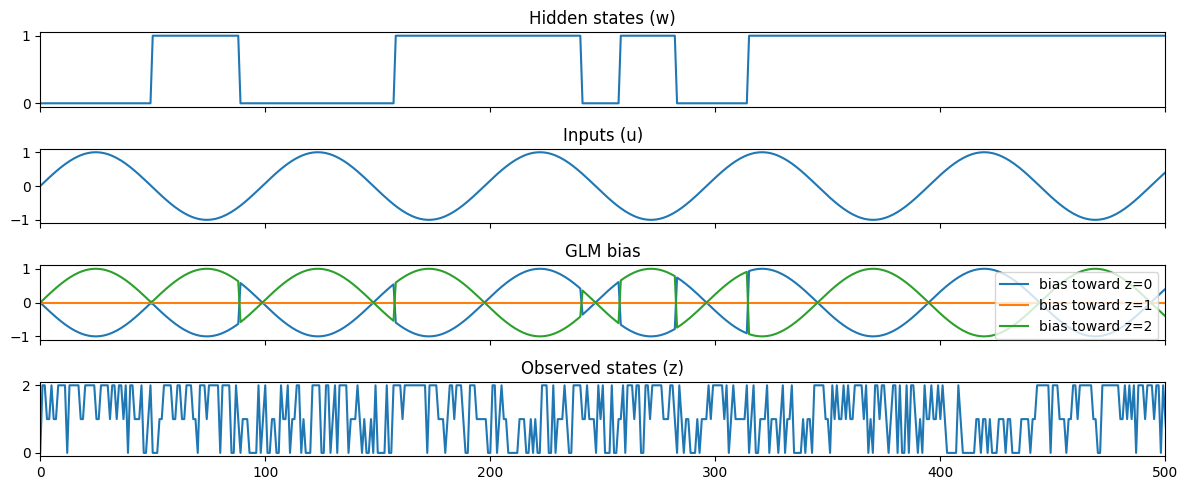

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(43)

N = 3  # number of observed states
M = 2  # number of hidden states
U = 1  # external input dimension
T = 5000  # number of time steps

# Transition probabilities between hidden states
pi = np.array([[0.99, 0.01],
               [0.01, 0.99]])

# GLM weight matrices
B1 = np.array([[-1], [0], [1]])
B2 = np.array([[1], [0], [-1]])
B = np.stack([B1, B2], axis=0)

# Baseline transition matrix between observed states
P = np.array([[0.8, 0.1, 0.1],
              [0.1, 0.8, 0.1],
              [0.1, 0.1, 0.8]])

# External input
u = np.sin(np.arange(T)/np.pi/5)[:,na]

# Simulate hidden states
w = np.zeros(T, dtype=int)
for t in range(1, T):
    w[t] = np.random.choice(M, p=pi[w[t-1]])

# Simulate observed states
z = np.zeros(T, dtype=int)
for t in range(1, T):
    transition_prob = np.exp(B[w[t]] @ u[t]) + P[z[t-1]]
    transition_prob /= transition_prob.sum()
    z[t] = np.random.choice(N, p=transition_prob)

# Plot results
fig,axs = plt.subplots(4,1,figsize=(12, 5), sharex=True)
axs[0].plot(w)
axs[1].plot(u)

glm_bias = (B[w]@(u[:,:,na])).squeeze(-1)
for i in range(N):
    axs[2].plot(glm_bias[:,i], label=f"bias toward z={i}")
axs[2].legend(loc='upper right')
axs[3].plot(z)

axs[0].set_title("Hidden states (w)")
axs[1].set_title("Inputs (u)")
axs[2].set_title("GLM bias")
axs[3].set_title("Observed states (z)")
axs[3].set_xlim([0,500])
plt.tight_layout()

In [13]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import blackjax

def logprob_fn(x, y, Sigma):
    """
    Log-pdf of ``(x, y) ~ MvNormal(0, Sigma)``.
    """
    z = jnp.concatenate([x, y])
    return jsp.stats.multivariate_normal.logpdf(
        x=z,
        mean=jnp.zeros_like(z),
        cov=Sigma
    )

# Specific example with x.shape == y.shape == (2,)
Sigma = jnp.array([
    [1., 0., .8, 0.],
    [0., 1., 0., .8],
    [.8, 0., 1., 0.],
    [0., .8, 0., 1.]
])

def logprob(x, y):
    return logprob_fn(x, y, Sigma=Sigma)

# MCMC initializers for each set of paramters
mwg_init_x = blackjax.mcmc.rmh.init
mwg_init_y = blackjax.mcmc.hmc.init

# MCMC updaters
mwg_step_fn_x = blackjax.mcmc.rmh.kernel()
mwg_step_fn_y = blackjax.mcmc.hmc.kernel()  # default integrator, etc.


def mwg_kernel(rng_key, state, parameters):
    """
    MBG kernel with RMH for ``x ~ p(x | y)`` and HMC for ``y ~ p(y | x)``.

    Parameters
    ----------
    rng_key
        The PRNG key.
    state
        Dictionary with elements `x` and `y`, where the former is an ``RMCState`` object
        and the latter is an ``HMCState`` object.
    parameters
        Dictionary with elements `x` and `y`, each of which is a dictionary of the parameters
        to the corresponding algorithm's ``step_fn()``.

    Returns
    -------
    Dictionary containing the updated ``state``.
    """
    rng_key_x, rng_key_y = jax.random.split(rng_key, num=2)

    # avoid modifying argument state as JAX functions should be pure
    state = state.copy()

    # --- update for x ---
    # conditional logdensity of x given y
    def logprob_x(x): return logprob(x=x, y=state["y"].position)

    # give state["x"] the right log_density
    state["x"] = mwg_init_x(
        position=state["x"].position,
        logprob_fn=logprob_x
    )
    # update state["x"]
    state["x"], _ = mwg_step_fn_x(
        rng_key=rng_key_x,
        state=state["x"],
        logprob_fn=logprob_x,
        **parameters["x"]
    )

    # --- update for y ---
    # conditional logdensity of y given x
    def logprob_y(y): return logprob(y=y, x=state["x"].position)

    # give state["y"] the right log_density
    state["y"] = mwg_init_y(
        position=state["y"].position,
        logprob_fn=logprob_y
    )
    # update state["y"]
    state["y"], _ = mwg_step_fn_y(
        rng_key=rng_key_y,
        state=state["y"],
        logprob_fn=logprob_y,
        **parameters["y"]
    )

    return state

In [14]:
parameters = {
    "x": {
        "sigma": .2 * jnp.eye(2)
    },
    "y": {
        "inverse_mass_matrix": jnp.array([1., 1.]),
        "num_integration_steps": 100,
        "step_size": 1e-2
    }
}

In [15]:
initial_state = {
    "x": mwg_init_x(
        position=jnp.array([0., 0.]),
        logprob_fn=lambda x: logprob(x=x, y=jnp.array([0., 0.]))
    ),
    "y": mwg_init_y(
        position=jnp.array([0., 0.]),
        logprob_fn=lambda y: logprob(y=y, x=jnp.array([0., 0.]))
    )
}

In [18]:
initial_state 

{'x': RMHState(position=DeviceArray([0., 0.], dtype=float32), log_probability=DeviceArray(-2.6541028, dtype=float32)),
 'y': HMCState(position=DeviceArray([0., 0.], dtype=float32), potential_energy=DeviceArray(2.6541028, dtype=float32), potential_energy_grad=DeviceArray([0., 0.], dtype=float32))}

In [16]:
def sampling_loop(rng_key, initial_state, parameters, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state = mwg_kernel(
            rng_key=rng_key,
            state=state,
            parameters=parameters
        )
        positions = {k: state[k].position for k in state.keys()}
        return state, positions

    keys = jax.random.split(rng_key, num_samples)
    _, positions = jax.lax.scan(one_step, initial_state, keys)

    return positions

In [17]:
rng_key = jax.random.PRNGKey(0)
positions = sampling_loop(rng_key, initial_state, parameters, 10_000)